In [1]:
# !pip install tensorly
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install torch-geometric

import collections
import math
import os
import os.path as osp
from tqdm import tqdm
from typing import List
import random
import time
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10
from sklearn import metrics
from tensorly import decomposition

import torch
from torch.functional import tensordot
from torch import nn, optim, Tensor
import torch_geometric
from torch_geometric.data import Dataset, Data, download_url, extract_zip
from torch_geometric.nn import MessagePassing
from torch_geometric.typing import Adj

In [2]:
path = '/home/owner/Documents/DEV/graphs/graphs_and_structural_analysis/Santander_Product_Recommendation/train.feather'
df = pd.read_feather(path)
df

,fecha_dato,cust_id,emp_index,residence,sex,age,first_date,new_cust,seniority,is_primary,...,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,age_grouped,income_grouped
0,2015-01-28,1375586,N,ES,H,35.0,2015-01-12,0.0,6.0,1.0,...,0,0,0,0,0,0.0,0.0,0,adult,Ordinary
1,2015-01-28,1050611,N,ES,V,23.0,2012-08-10,0.0,35.0,1.0,...,0,0,0,0,0,0.0,0.0,0,adult,Low
2,2015-01-28,1050612,N,ES,V,23.0,2012-08-10,0.0,35.0,1.0,...,0,0,0,0,0,0.0,0.0,0,adult,Ordinary
3,2015-01-28,1050613,N,ES,H,22.0,2012-08-10,0.0,35.0,1.0,...,0,0,0,0,0,0.0,0.0,0,adult,Ordinary
4,2015-01-28,1050614,N,ES,V,23.0,2012-08-10,0.0,35.0,1.0,...,0,0,0,0,0,0.0,0.0,0,adult,Median-high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391596,2016-05-28,1166765,N,ES,V,22.0,2013-08-14,0.0,33.0,1.0,...,0,0,0,0,0,0.0,0.0,0,adult,Low
391597,2016-05-28,1166764,N,ES,V,23.0,2013-08-14,0.0,33.0,1.0,...,0,0,0,0,0,0.0,0.0,0,adult,Low
391598,2016-05-28,1166763,N,ES,H,47.0,2013-08-14,0.0,33.0,1.0,...,0,0,0,0,0,0.0,0.0,0,senior,Median-high
391599,2016-05-28,1166789,N,ES,H,22.0,2013-08-14,0.0,33.0,1.0,...,0,0,0,0,0,0.0,0.0,0,adult,High


In [3]:
col_names = {"ncodpers":"cust_id", "ind_empleado":"emp_index", "pais_residencia":"residence",
            "sexo":"sex","fecha_alta":"first_date","ind_nuevo":"new_cust","antiguedad":"seniority",
            "indrel":"is_primary","ult_fec_cli_1t":"last_primary_date","indrel_1mes":"cust_type",
            "tiprel_1mes":"cust_rel_type","indresi":"residence_index","indext":"foreigner_index",
            "conyuemp":"spouse_index","canal_entrada":"channel","cod_prov":"province","nomprov":"province_name",
            "ind_actividad_cliente":"active_index","renta":"income","segmento":"segment"
            }

df.rename(col_names, axis = 1, inplace = True)

In [4]:
df['sex'] = df['sex'].map({'H': 'M', 'V': 'F'})

In [5]:
df.age = pd.to_numeric(df.age, errors='coerce')
df.income = pd.to_numeric(df.income, errors='coerce')
df.seniority = pd.to_numeric(df.seniority, errors='coerce')
df.first_date = pd.to_datetime(df.first_date, errors = 'coerce')
df.cust_type = pd.to_numeric(df.cust_type, errors='coerce')
df['fecha_dato'] = pd.to_datetime(df['fecha_dato'])

In [6]:
# For features with missing values percentage < 10%, use the most common factor level to impute
cols = ['emp_index','residence','sex','first_date','new_cust','is_primary',"cust_type","cust_rel_type",
       "province","province_name","active_index","channel","segment"]

for i in cols:
    print(df[i].value_counts())
    df.loc[df[i].isnull(), i] = df[i].value_counts().index[0]
    
# For features with missing value accounts for over 10%, impute their missing values based on the mean at different dimensions
# For Income, impute the missings using the medians of Customer Segment and Province
df['income'].fillna(df['income'].mean(), inplace = True)

N    13638711
B        3566
F        2523
A        2492
S          17
Name: emp_index, dtype: int64
ES    13581444
FR        5161
AR        4835
DE        4625
GB        4605
        ...   
ZW          11
DJ          11
JM          11
BM           6
MT           2
Name: residence, Length: 118, dtype: int64
F    7452056
M    6195253
Name: sex, dtype: int64
2014-07-28    85123
2014-10-03    54287
2014-08-04    45746
2013-10-14    40804
2013-08-03    33414
              ...  
2014-04-27       11
2015-05-31        9
2014-05-01        7
2010-07-04        4
2009-12-25        4
Name: first_date, Length: 6756, dtype: int64
0.0    12836102
1.0      811207
Name: new_cust, dtype: int64
1.0     13622516
99.0       24793
Name: is_primary, dtype: int64
1.0    13641336
3.0        4350
2.0        1317
4.0         306
Name: cust_type, dtype: int64
I    7454656
A    6187123
P       4656
R        870
N          4
Name: cust_rel_type, dtype: int64
28.0    4503191
8.0     1275219
46.0     682304
41.0     6

In [7]:
# filling dummies with NA by 0
dummies = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1',
          'ind_cco_fin_ult1', 'ind_cder_fin_ult1',
          'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
          'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
          'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1',
          'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
          'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
          'ind_hip_fin_ult1', 'ind_plan_fin_ult1',
          'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
          'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
          'ind_viv_fin_ult1', 'ind_nomina_ult1',
          'ind_nom_pens_ult1', 'ind_recibo_ult1']

df[dummies] = df[dummies].fillna(0)

In [8]:
# Drop the last primary date and spouse index fields given over 99% missing values
# df.drop(['last_primary_date','spouse_index'], axis = 1, inplace = True)

# Инжиниринг фич

In [9]:
# 1) Age group: group the age for lifestages: young, adult, senior, elder
age_group = [0, 20, 45, 65, 100]
age_labels = ['young', 'adult', 'senior', 'elder']

df['age_grouped'] = pd.cut(df.age, bins = age_group, labels = age_labels)

In [10]:
# 2) Income Group: group the incomes at Low, Ordinary, Median-high and High classes at (real case may be more complex)
import numpy as np
df_income_group = [0, np.nanpercentile(df['income'], 25), np.nanpercentile(df['income'], 50), np.nanpercentile(df['income'], 75), np.nanpercentile(df['income'], 100)]
income_labels = ['Low','Ordinary','Median-high','High']

df['income_grouped'] = pd.cut(df['income'], df_income_group, labels = income_labels)

In [11]:
# categorical = df.columns[(df.dtypes == "object") | (df.dtypes == "category")]
# for column in categorical:
#     df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
#     df.drop(columns=column, inplace=True)

In [12]:
print("[", end="")
for column in df.columns: print(f"{column}, ", end="")
print("]")

[fecha_dato, cust_id, emp_index, residence, sex, age, first_date, new_cust, seniority, is_primary, cust_type, cust_rel_type, residence_index, foreigner_index, channel, indfall, tipodom, province, province_name, active_index, income, segment, ind_ahor_fin_ult1, ind_aval_fin_ult1, ind_cco_fin_ult1, ind_cder_fin_ult1, ind_cno_fin_ult1, ind_ctju_fin_ult1, ind_ctma_fin_ult1, ind_ctop_fin_ult1, ind_ctpp_fin_ult1, ind_deco_fin_ult1, ind_deme_fin_ult1, ind_dela_fin_ult1, ind_ecue_fin_ult1, ind_fond_fin_ult1, ind_hip_fin_ult1, ind_plan_fin_ult1, ind_pres_fin_ult1, ind_reca_fin_ult1, ind_tjcr_fin_ult1, ind_valo_fin_ult1, ind_viv_fin_ult1, ind_nomina_ult1, ind_nom_pens_ult1, ind_recibo_ult1, age_grouped, income_grouped, ]


In [13]:
for dummy1 in dummies:
    for dummy2 in dummies:
        if dummy1 == dummy2: continue
        df[dummy2] = (~df[dummy1].astype(bool)) & df[dummy2].astype(bool)

In [14]:
df['service_name'] = pd.from_dummies(df[dummies], default_category="Unknown")

In [15]:
df['service_name'].value_counts()

ind_cco_fin_ult1     11503962
ind_cno_fin_ult1       851859
ind_ctop_fin_ult1      443799
Unknown                224806
ind_ecue_fin_ult1      174677
                       ...   
ind_ahor_fin_ult1         957
ind_deme_fin_ult1         945
ind_nom_pens_ult1         805
ind_cder_fin_ult1         703
ind_aval_fin_ult1         106
Name: service_name, Length: 25, dtype: int64

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['service_id'] = le.fit_transform(df['service_name'])

# Постобработка

In [17]:
products_by_age_groups = df.groupby('age_grouped')['service_name'].value_counts()
products_by_age_groups = products_by_age_groups.groupby(level=0).head(5).unstack().fillna(0).sort_index(axis=1)

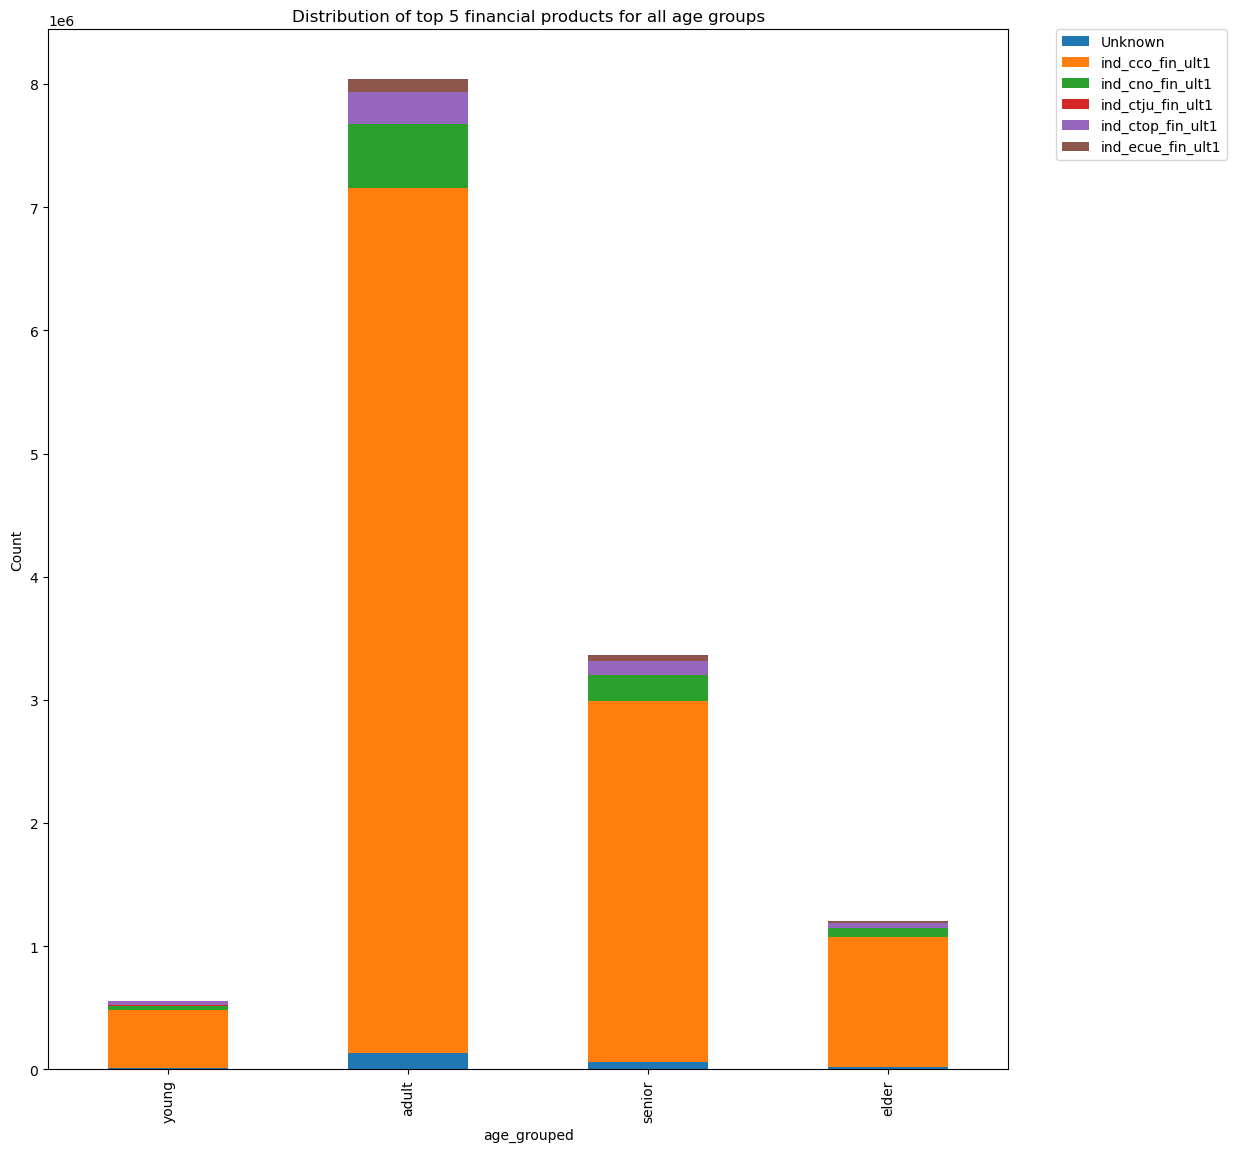

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
products_by_age_groups.plot(kind='bar', stacked=True, ax=ax)

plt.title('Distribution of top 5 financial products for all age groups')
plt.ylabel('Count')

plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=1.5, wspace=0.4, hspace=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [19]:
products_by_sex = df.groupby('sex')['service_name'].value_counts()
products_by_sex = products_by_sex.groupby(level=0).head(5).unstack().fillna(0).sort_index(axis=1)

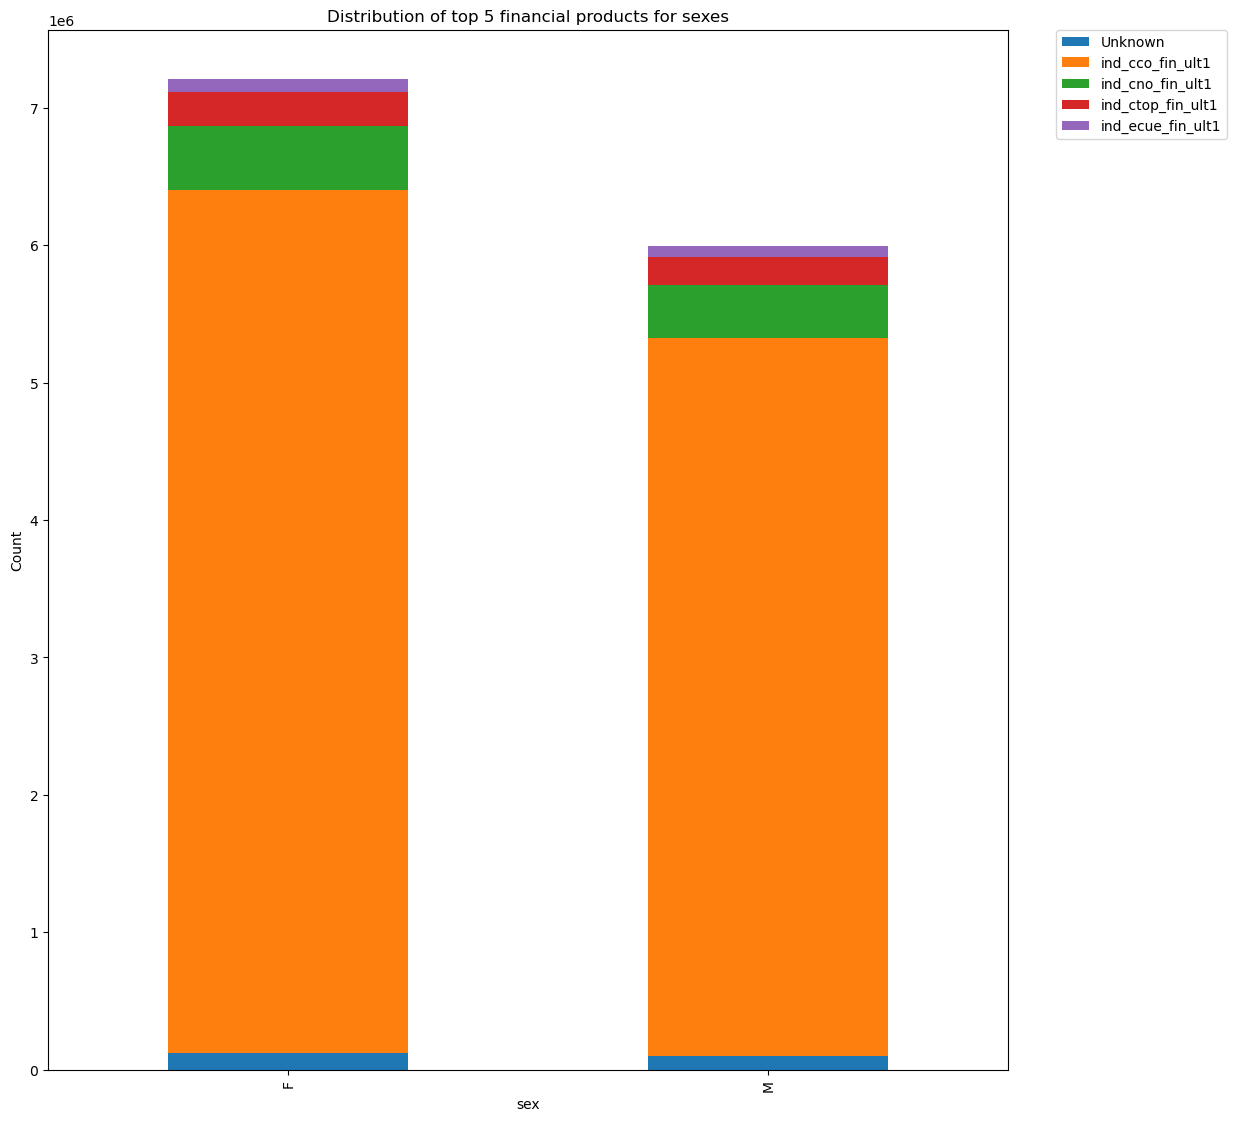

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
products_by_sex.plot(kind='bar', stacked=True, ax=ax)

plt.title('Distribution of top 5 financial products for sexes')
plt.ylabel('Count')

plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=1.5, wspace=0.4, hspace=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [21]:
df.columns

Index(['fecha_dato', 'cust_id', 'emp_index', 'residence', 'sex', 'age',
       'first_date', 'new_cust', 'seniority', 'is_primary', 'cust_type',
       'cust_rel_type', 'residence_index', 'foreigner_index', 'channel',
       'indfall', 'tipodom', 'province', 'province_name', 'active_index',
       'income', 'segment', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1',
       'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1',
       'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
       'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1',
       'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
       'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1',
       'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
       'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1',
       'ind_recibo_ult1', 'age_grouped', 'income_grouped', 'service_name',
       'service_id'],
      dtype='object')

In [22]:
train = df[['cust_id', 'service_name', 'service_id']]

In [23]:
train = train.rename({'cust_id': 'user_id'}, axis = 1).sample(len(train) // 100)
train_mask = df.index.isin(train.index)
test = df[~train_mask][['cust_id', 'service_name', 'service_id']].rename({'cust_id': 'user_id'}, axis = 1).sample(len(train) // 3)

In [24]:
import networkx as nx
G = nx.Graph()

In [25]:
user_nodes = train['user_id'].unique()
item_nodes = train['service_id'].unique()
G.add_nodes_from(user_nodes, bipartite=0)
G.add_nodes_from(item_nodes, bipartite=1)
for user, item in zip(train['user_id'], train['service_id']):
    G.add_edge(user, item, weight=1)

nx.write_gexf(G, 'graph.gexf')

In [26]:
len(G.edges)

129610

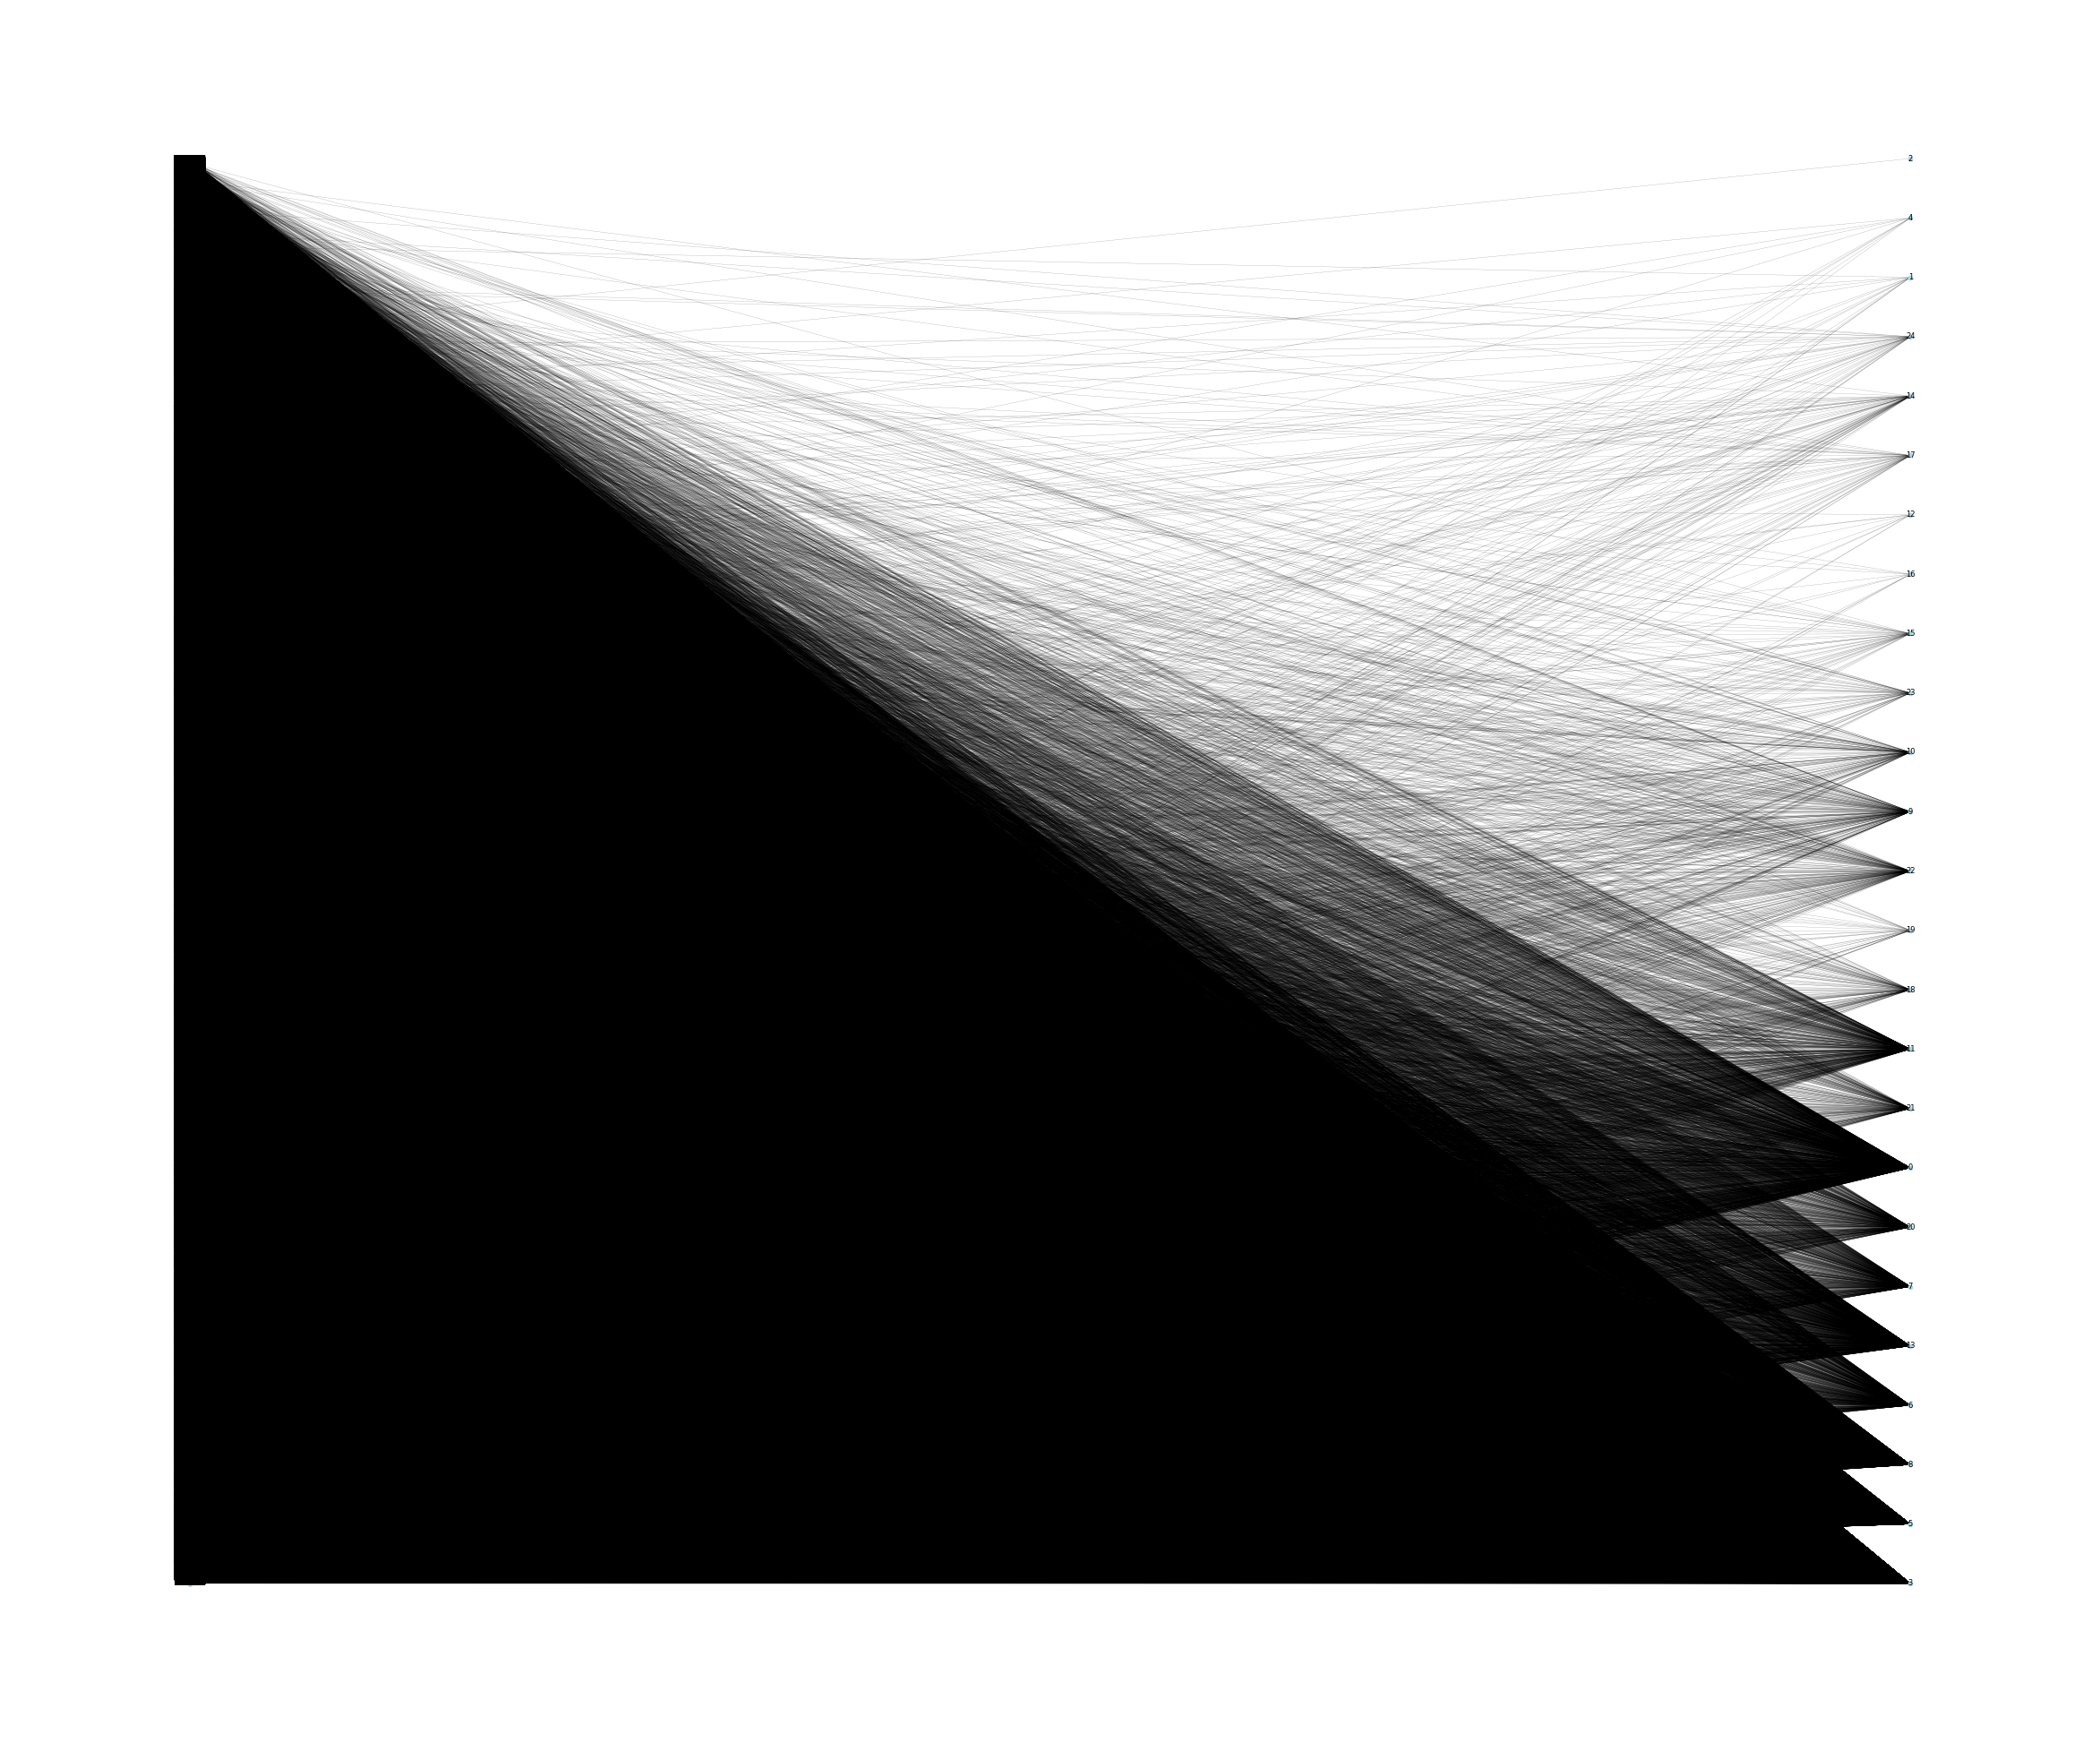

In [27]:
plt.figure(figsize=(30, 25))
pos = nx.bipartite_layout(G, nodes = user_nodes, )
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.4)
nx.draw_networkx_labels(G, pos, font_size=6, font_family='sans-serif')
plt.axis('off')
plt.show()

## Model Architecture

First, let's take a look at the graph convolutional layers that will power our recommender system GNN. Then, we can implement a wrapper to stack multiple convolutional layers.

In [28]:
import random
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp


from sklearn.model_selection import train_test_split
from networkx.algorithms import bipartite
from tqdm import tqdm
import matplotlib.pyplot as plt
import recmetrics

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [30]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train['user_id_idx'] = le_user.fit_transform(train['user_id'].values)
train['service_id_idx'] = le_item.fit_transform(train['service_id'].values)

In [31]:
train_user_ids = train['user_id'].unique()
train_item_ids = train['service_id'].unique()

test = test[
  (test['user_id'].isin(train_user_ids)) & \
  (test['service_id'].isin(train_item_ids))
]

In [32]:
test['user_id_idx'] = le_user.transform(test['user_id'].values)
test['service_id_idx'] = le_item.transform(test['service_id'].values)

In [33]:
n_users = train['user_id_idx'].nunique()
n_items = train['service_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  127002
Number of unique Items :  25


In [34]:
u_t = torch.LongTensor(train.user_id_idx.to_numpy())
i_t = torch.LongTensor(train.service_id_idx.to_numpy()) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[ 60418, 112690,  74422,  ..., 127005, 127005, 127005],
        [127005, 127005, 127005,  ...,  97027,     16,  41422]],
       device='cuda:0')

In [35]:
def data_loader(data, batch_size, n_usr, n_itm):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['service_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['service_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['service_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items)).to(device) + n_usr,
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )


class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):
    super().__init__(aggr='add')

  def forward(self, x, edge_index):
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j


class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim,
      num_layers,
      num_users,
      num_items,
  ):
    super(RecSysGNN, self).__init__()

    self.embedding = nn.Embedding(num_users + num_items, latent_dim)
    self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))
    self.init_parameters()


  def init_parameters(self):
    nn.init.normal_(self.embedding.weight, std=0.1)


  def forward(self, edge_index):
    emb0 = self.embedding.weight
    embs = [emb0]

    emb = emb0
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    out = (
      torch.mean(torch.stack(embs, dim=0), dim=0)
    )

    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users],
        out[pos_items],
        out[neg_items],
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )


def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) +
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))

  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

  return bpr_loss, reg_loss


def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
  test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

  relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

  i = torch.stack((
    torch.LongTensor(train['user_id_idx'].values),
    torch.LongTensor(train['service_id_idx'].values)
  ))
  v = torch.ones((len(train)), dtype=torch.float64)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)

  relevance_score = torch.mul(relevance_score, (1 - interactions_t))

  topk_relevance_indices = torch.topk(relevance_score, K).indices
  topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
  topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

  test_interacted_items = test_data.groupby('user_id_idx')['service_id_idx'].apply(list).reset_index()
  metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
  metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.service_id_idx, metrics_df.top_rlvnt_itm)]

  metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['service_id_idx']), axis = 1)
  metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

  return metrics_df['recall'].mean(), metrics_df['precision'].mean()


def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(len(train)/BATCH_SIZE)

      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []

      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()
          

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          test_topK_recall,  test_topK_precision = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test, K
          )

      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))

  return (
    loss_list_epoch,
    bpr_loss_list_epoch,
    reg_loss_list_epoch,
    recall_list,
    precision_list
  )

In [54]:
latent_dim = 64
n_layers = 3

EPOCHS = 10
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 20

In [55]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)

In [56]:
light_loss, light_bpr, light_reg, light_recall, light_precision = train_and_eval(lightgcn, optimizer, train)

100%|██████████| 10/10 [41:18<00:00, 247.83s/it]


In [57]:
epoch_list = [(i+1) for i in range(EPOCHS)]

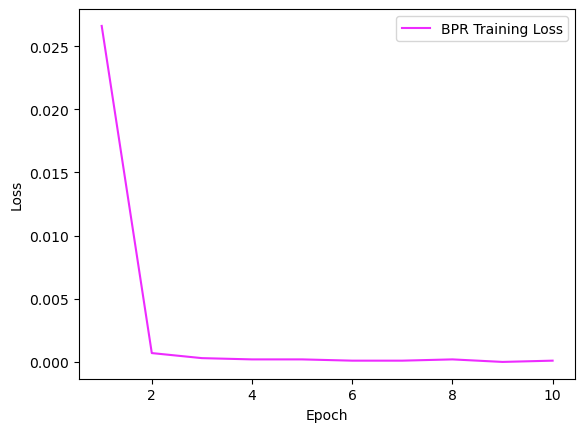

In [58]:
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

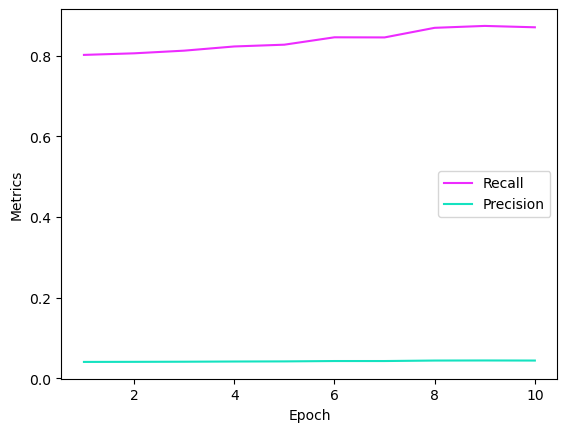

In [59]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

In [60]:
def get_preds(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
  test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
  relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

  i = torch.stack((
    torch.LongTensor(train['user_id_idx'].values),
    torch.LongTensor(train['service_id_idx'].values)
  ))
  v = torch.ones((len(train)), dtype=torch.float64)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)

  relevance_score = torch.mul(relevance_score, (1 - interactions_t))

  topk_relevance_indices = torch.topk(relevance_score, K).indices
  topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
  topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

  test_interacted_items = test_data.groupby('user_id_idx')['service_id_idx'].apply(list).reset_index()
  return pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])

In [61]:
_, out = lightgcn(train_edge_index)
final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
preds = get_preds(final_user_Embed, final_item_Embed, n_users, n_items, train, test, 25)

In [62]:
users_to_predict = [test.user_id_idx.unique()[0]]

In [63]:
def apk(actual, predicted, k=10):

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):

    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [64]:
MAP = []
MAR = []

for k in range(1, 25):
    y_true = []
    y_pred = []
    for user in users_to_predict:
        # print((preds["user_id_idx"] == user).any())
        true = list(preds[preds["user_id_idx"] == user]["service_id_idx"])[0]
        pred = list(preds[preds["user_id_idx"] == user]["top_rlvnt_itm"])[0][:k]
    #     true = users_movies_test[user]
    #     pred = [p[0] for p in users_movies_pred[user]][:k]
        y_true.append(true)
        y_pred.append(pred)

    MAR.append(recmetrics.mark(y_true, y_pred, k = k))
    MAP.append(mapk(y_true, y_pred, k = k))

In [65]:
MAP

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091]

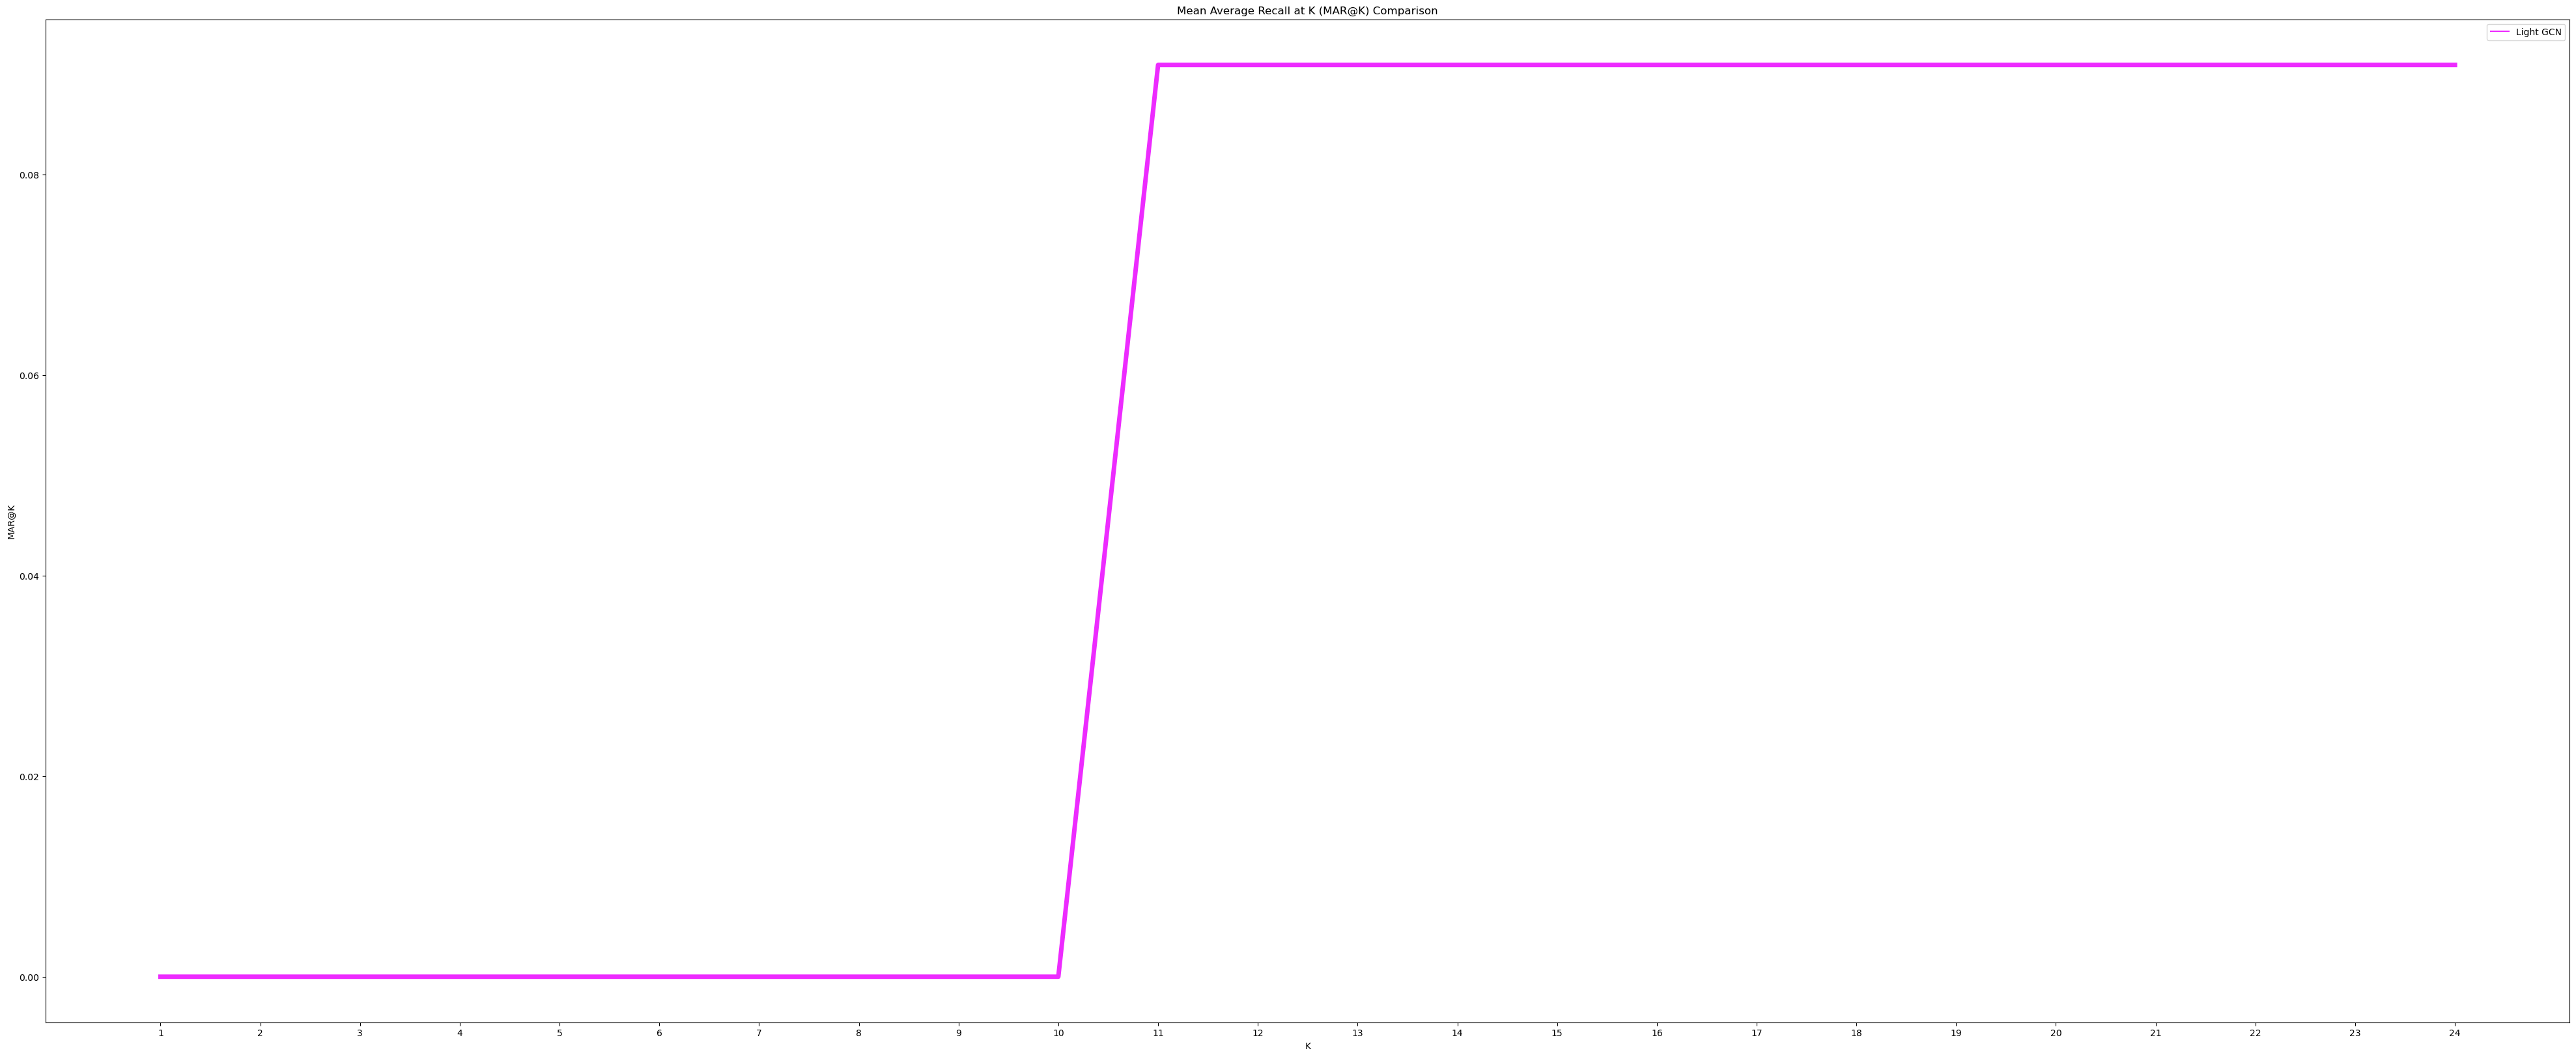

In [66]:
plt.figure(figsize=(50, 20))
recmetrics.mark_plot([MAR], ["Light GCN"], range(1, 25))

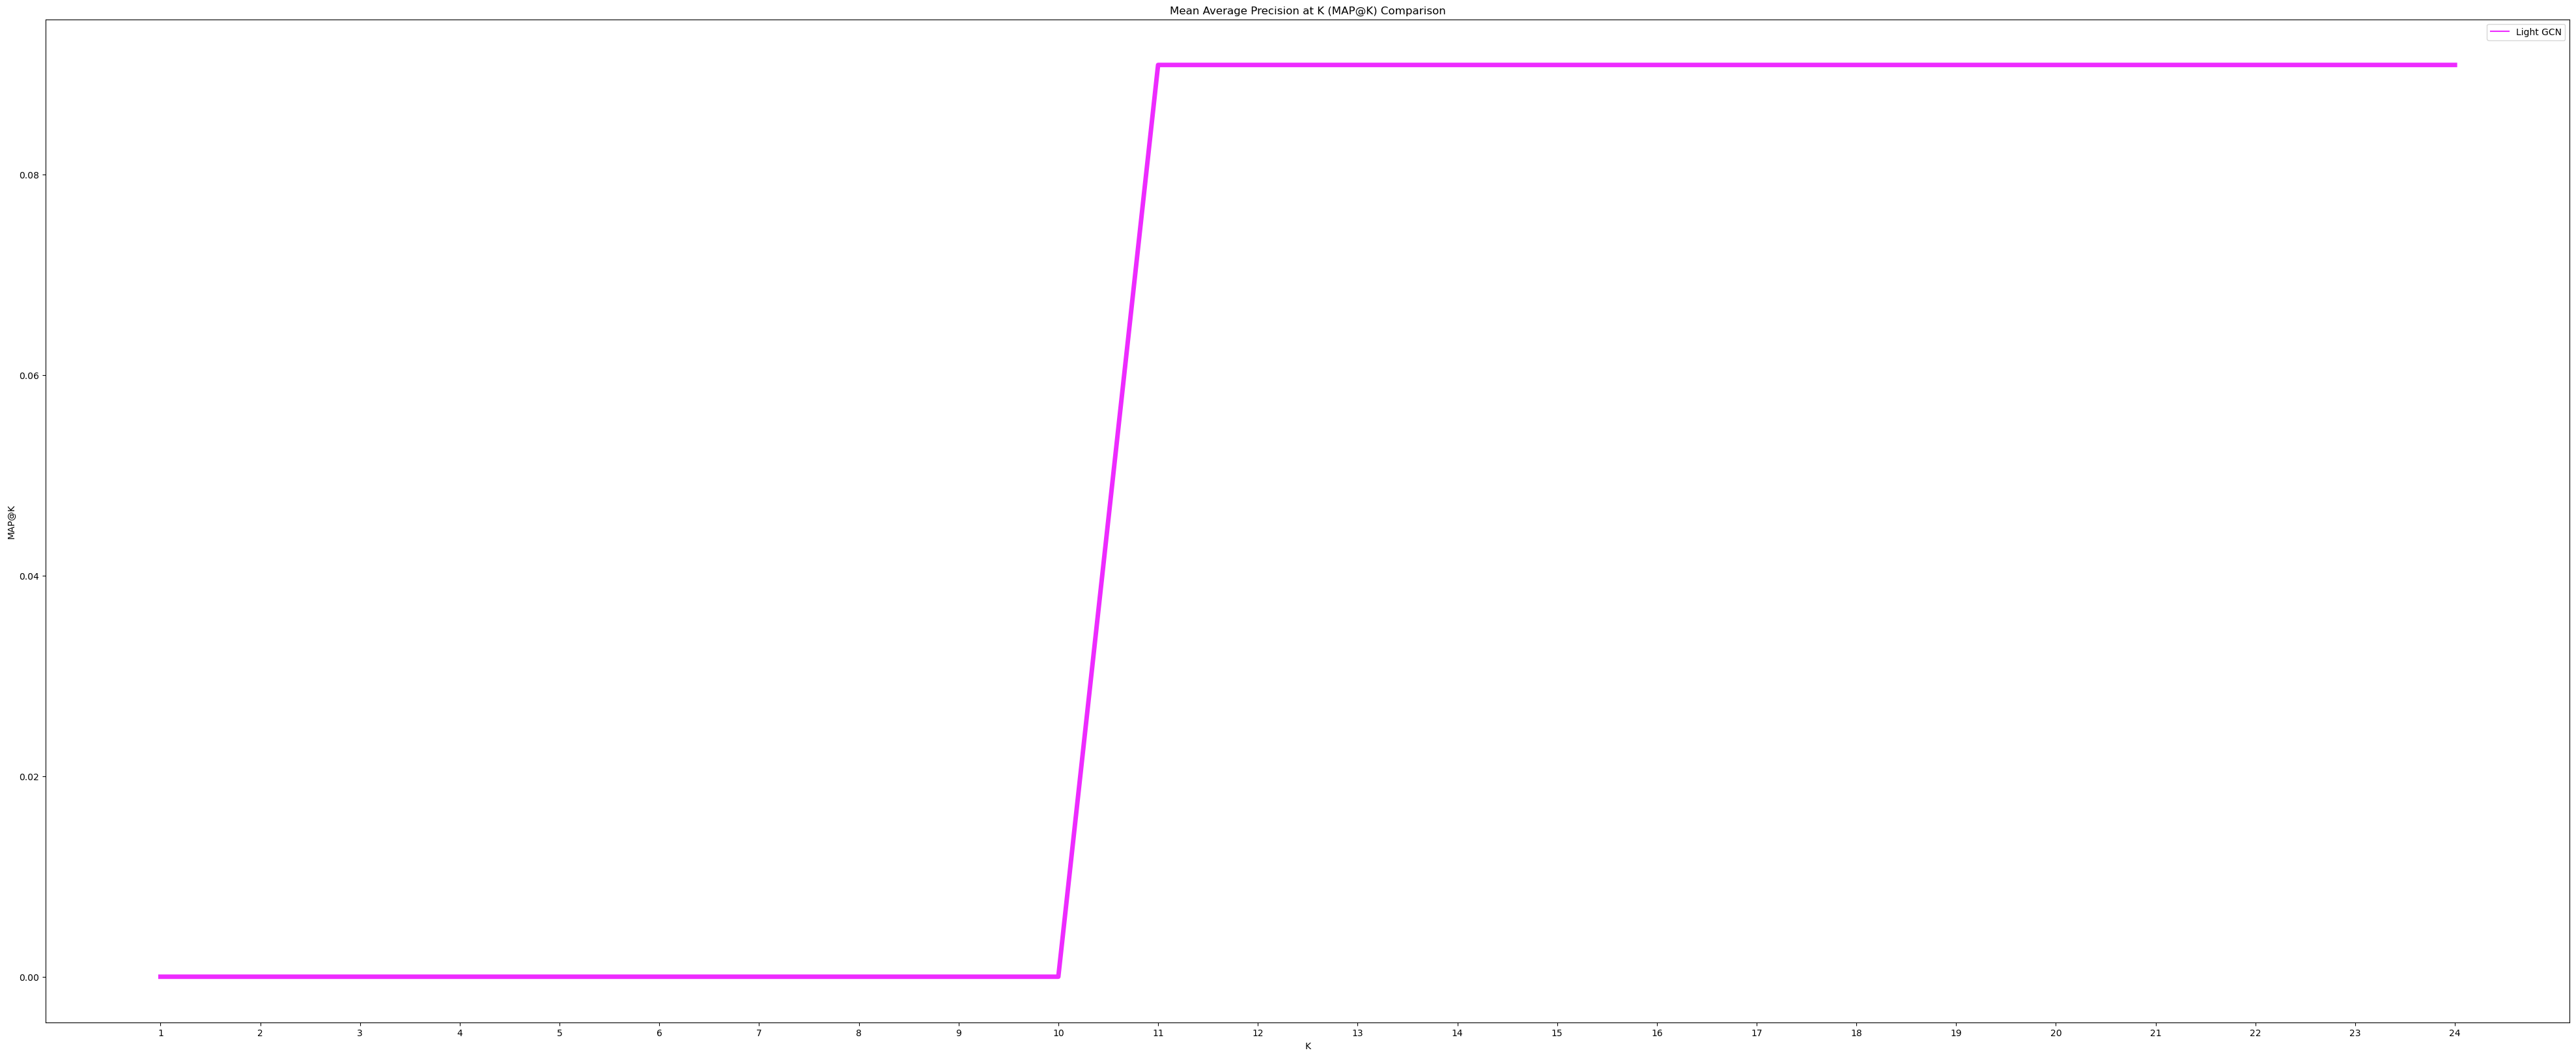

In [67]:
plt.figure(figsize=(50, 20))
recmetrics.mapk_plot([MAP], ["Light GCN"], range(1, 25))

In [69]:
import pickle

fileObj = open('gcn.pkl', 'wb')
pickle.dump(lightgcn, fileObj)

In [70]:
fileObj = open('gcn.pkl', 'rb')
tmp = pickle.load(fileObj)